# Импорт библиотек

In [1]:
import pandas as pd 
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import (ViTFeatureExtractor, BertTokenizer, VisionEncoderDecoderConfig,
                          VisionEncoderDecoderModel, default_data_collator, 
                          Seq2SeqTrainer, Seq2SeqTrainingArguments)
from datasets import load_metric

# Загрузка данных

In [2]:
train_df = pd.read_csv('train.csv').reset_index(drop=True)
val_df = pd.read_csv('val.csv').reset_index(drop=True)
test_df = pd.read_csv('test.csv').reset_index(drop=True)

# Функции

In [3]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df,feature_extractor,tokenizer, max_target_length=103):
        self.root_dir = root_dir
        self.df = df
        # self.processor = processor #feature_extractor
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = str(self.df['filmId'][idx]) + '.jpg'
        text = self.df['description'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        image = image.resize([224, 224])
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
       
        labels = self.tokenizer(
            text, 
            truncation='longest_first',
            padding="max_length", 
            # return_tensors="pt",
            max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
metric = load_metric('sacrebleu')

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    bleu = metric.compute(predictions=[pred_str], references=[label_str])

    return {"bleu": bleu}

/tmp/ipykernel_15664/2447590034.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('sacrebleu')


# Обучение

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

train_dataset = IAMDataset(
    root_dir='../../data/img/',
    df=train_df,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer)

eval_dataset = IAMDataset(
    root_dir='../../data/img/',
    df=val_df,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 23556
Number of validation examples: 2945


In [6]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "DeepPavlov/rubert-base-cased"
)

for param in model.encoder.parameters():
    param.requires_grad = False
    
for param in model.base_model.encoder.parameters():
    param.requires_grad = False

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 103
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['bert.encoder.layer.10.crossattention.self.query.weight', 'bert.encoder.layer.8.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.7.crossattention.self.que

In [7]:
encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("checkpoint-350000")
model = VisionEncoderDecoderModel.from_pretrained("checkpoint-350000", config=encoder_decoder_config)

model.config.max_length = 103

for param in model.encoder.parameters():
    param.requires_grad = False
    
for param in model.base_model.encoder.parameters():
    param.requires_grad = False

In [8]:
model.config

VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "checkpoint-350000",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "DeepPavlov/rubert-base-cased",
    "add_cross_attention": true,
    "architectures": [
      "BertModel"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "directionality": "bidi",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0"

In [9]:
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=40,
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=10_000,
    eval_steps=10_000
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using cuda_amp half precision backend
/home/slivka_83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23556
  Num Epochs = 40
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 235560
  Number of trainable parameters = 206341371
Trainer is attempting to log a value of "{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': True, 'cross_attention_hidden_size': No

Step,Training Loss,Validation Loss,Bleu
10000,0.360900,7.813661,"{'score': 5.575908001570355, 'counts': [10786, 17010, 9432, 3412], 'totals': [157211, 157210, 157209, 157208], 'precisions': [6.860843070777491, 10.819922396794096, 5.999656508215178, 2.170373009007175], 'bp': 1.0, 'sys_len': 157211, 'ref_len': 99}"
20000,0.192300,7.888307,"{'score': 5.534717279488117, 'counts': [11114, 17260, 9695, 3650], 'totals': [164001, 164000, 163999, 163998], 'precisions': [6.776787946414961, 10.524390243902438, 5.911621412325685, 2.2256368980109515], 'bp': 1.0, 'sys_len': 164001, 'ref_len': 99}"
30000,0.140400,8.023189,"{'score': 5.712516449890402, 'counts': [11204, 16889, 9293, 3396], 'totals': [153887, 153886, 153885, 153884], 'precisions': [7.280666982916036, 10.975007473064476, 6.038925171394223, 2.206857113150165], 'bp': 1.0, 'sys_len': 153887, 'ref_len': 99}"
40000,0.164800,8.142317,"{'score': 5.8574813540986295, 'counts': [11180, 16740, 9159, 3339], 'totals': [148494, 148493, 148492, 148491], 'precisions': [7.528923727558015, 11.273258672125959, 6.168009050992646, 2.248621128553246], 'bp': 1.0, 'sys_len': 148494, 'ref_len': 99}"
50000,0.125500,8.270433,"{'score': 5.538161014280308, 'counts': [11784, 17888, 9951, 3693], 'totals': [169400, 169399, 169398, 169397], 'precisions': [6.956316410861866, 10.559684531785901, 5.874331456097474, 2.180085833869549], 'bp': 1.0, 'sys_len': 169400, 'ref_len': 99}"
60000,0.095400,8.438633,"{'score': 5.69349968945276, 'counts': [11968, 17711, 9848, 3658], 'totals': [164187, 164186, 164185, 164184], 'precisions': [7.289249453367197, 10.787156030355815, 5.998111885982276, 2.227988110899966], 'bp': 1.0, 'sys_len': 164187, 'ref_len': 99}"
70000,0.130500,8.429495,"{'score': 5.701650617206032, 'counts': [12128, 18026, 9981, 3630], 'totals': [165461, 165460, 165459, 165458], 'precisions': [7.329823946428464, 10.894476006285506, 6.032310119123166, 2.193910237039007], 'bp': 1.0, 'sys_len': 165461, 'ref_len': 99}"
80000,0.057900,8.617245,"{'score': 5.663905296914447, 'counts': [11601, 17646, 9699, 3593], 'totals': [162263, 162262, 162261, 162260], 'precisions': [7.149504199971651, 10.875004622154293, 5.977406770573335, 2.2143473437692593], 'bp': 1.0, 'sys_len': 162263, 'ref_len': 99}"
90000,0.100000,8.676436,"{'score': 5.753784218124326, 'counts': [12033, 17954, 9816, 3604], 'totals': [162504, 162503, 162502, 162501], 'precisions': [7.4047408063801505, 11.048411413943127, 6.040541039494898, 2.2178325056461192], 'bp': 1.0, 'sys_len': 162504, 'ref_len': 99}"
100000,0.053100,8.750635,"{'score': 5.539877698046993, 'counts': [11891, 17643, 9646, 3506], 'totals': [165669, 165668, 165667, 165666], 'precisions': [7.177564903512425, 10.649612477967985, 5.822523495928579, 2.1163063030434732], 'bp': 1.0, 'sys_len': 165669, 'ref_len': 99}"


***** Running Evaluation *****
  Num examples = 2945
  Batch size = 4
Trainer is attempting to log a value of "{'score': 5.575908001570355, 'counts': [10786, 17010, 9432, 3412], 'totals': [157211, 157210, 157209, 157208], 'precisions': [6.860843070777491, 10.819922396794096, 5.999656508215178, 2.170373009007175], 'bp': 1.0, 'sys_len': 157211, 'ref_len': 99}" of type <class 'dict'> for key "eval_bleu" as a metric. MLflow's log_metric() only accepts float and int types so we dropped this attribute.
Trainer is attempting to log a value of "{'score': 5.575908001570355, 'counts': [10786, 17010, 9432, 3412], 'totals': [157211, 157210, 157209, 157208], 'precisions': [6.860843070777491, 10.819922396794096, 5.999656508215178, 2.170373009007175], 'bp': 1.0, 'sys_len': 157211, 'ref_len': 99}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./checkpoint-10000
Configura

***** Running Evaluation *****
  Num examples = 2945
  Batch size = 4
Trainer is attempting to log a value of "{'score': 5.663905296914447, 'counts': [11601, 17646, 9699, 3593], 'totals': [162263, 162262, 162261, 162260], 'precisions': [7.149504199971651, 10.875004622154293, 5.977406770573335, 2.2143473437692593], 'bp': 1.0, 'sys_len': 162263, 'ref_len': 99}" of type <class 'dict'> for key "eval_bleu" as a metric. MLflow's log_metric() only accepts float and int types so we dropped this attribute.
Trainer is attempting to log a value of "{'score': 5.663905296914447, 'counts': [11601, 17646, 9699, 3593], 'totals': [162263, 162262, 162261, 162260], 'precisions': [7.149504199971651, 10.875004622154293, 5.977406770573335, 2.2143473437692593], 'bp': 1.0, 'sys_len': 162263, 'ref_len': 99}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./checkpoint-80000
Configu

KeyboardInterrupt: 

In [15]:
max_length = 103
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = []
image_path = 'test_img1.jpg';
i_image = Image.open(image_path)
i_image = i_image.resize([224,224])

if i_image.mode != "RGB":
    i_image = i_image.convert(mode="RGB")

# model.feat
images.append(i_image)
pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
preds

['Когда она просыпается, она понимает, что в отношениях с её бывшей любовью происходят странные и ужасные вещи. Её 20 - летие тоже день рождения. Он – собирается сделать ей предложение. Она с нетерпением ждет сюрпризов, но всё идет наперекосяк. Наконец, происходит то, что происходит в её жизни – обычные истории о том, как она могла всё и как просыпается.']

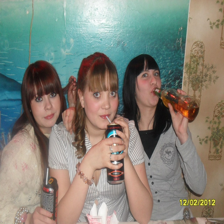

In [11]:
i_image

In [9]:
trainer.save_model('model_ru')

Error in callback <function _WandbInit._resume_backend at 0x7f72d0849ee0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Saving model checkpoint to model_ru
Configuration saved in model_ru/config.json
Model weights saved in model_ru/pytorch_model.bin
Feature extractor saved in model_ru/preprocessor_config.json


Error in callback <function _WandbInit._pause_backend at 0x7f72d0849f70> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [ ]:
# import gc
# del x
# gc.collect()
# torch.cuda.empty_cache()